# Week 6: Make Naive Predictions 2

In [196]:
import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,5)

import json
import pickle

In [227]:
complete_df = pd.read_csv("data/116_edit",sep = "\t" , header = 0)
complete_df['calibrated_time'] = pd.to_datetime(complete_df['calibrated_time'])

In [18]:
complete_df.head()

,raw_index,route,licence_plate_number,calibrated_time,longitude,latitude,delta_lon,delta_lat,delta_time
0,19,116,粤E19204,2015-07-01 00:01:35,113.14631,23.02181,0.0,0.0,5
1,39,116,粤E19204,2015-07-01 00:01:40,113.14631,23.02181,0.0,0.0,5
2,57,116,粤E19204,2015-07-01 00:01:45,113.14631,23.02181,0.0,0.0,5
3,82,116,粤E19204,2015-07-01 00:01:50,113.14631,23.02181,0.0,0.0,5
4,102,116,粤E19204,2015-07-01 00:01:55,113.14631,23.02181,0.0,0.0,5


In [189]:
start_range = [(113.145, 113.147), (23.0205, 23.0225)]
end_range = [(113.0165, 113.0185), (23.046, 23.048)]

In [201]:
# shifts = []
# for bus in complete_df.licence_plate_number.unique().tolist()[:]:
#     temp_bus = complete_df[complete_df.licence_plate_number == bus]
#     for i in temp_bus.index:
#         if temp_bus.loc[i,"longitude"] < start_range[0][1] and temp_bus.loc[i,"longitude"] > start_range[0][0] and temp_bus.loc[i,"latitude"] < start_range[1][1] and temp_bus.loc[i,"latitude"] > start_range[1][0]:
#             # if within departure station, renew the shift list
# #             temp = [(i, temp_bus.loc[i,"longitude"], temp_bus.loc[i,"latitude"])]
#             temp = [i]
#         elif temp_bus.loc[i,"longitude"] < end_range[0][1] and temp_bus.loc[i,"longitude"] > end_range[0][0] and temp_bus.loc[i,"latitude"] < end_range[1][1] and temp_bus.loc[i,"latitude"] > end_range[1][0]:
#             # if within terminal station, check if the length of the list satisfied our requirement
#             if len(temp)> 100 :
#                 if (temp_bus.loc[temp[-1],"calibrated_time"] - temp_bus.loc[temp[0],"calibrated_time"]).total_seconds()>3600 and (temp_bus.loc[temp[-1],"calibrated_time"] - temp_bus.loc[temp[0],"calibrated_time"]).total_seconds()<9600 :
#                     shifts.append(temp)
#             temp = []

#         elif len(temp)>0:
#             # if between the two stations, add it to the list
# #             temp.append((i, temp_bus.loc[i,"longitude"], temp_bus.loc[i,"latitude"]))
#             temp.append(i)

# #     print complete_df[complete_df.licence_plate_number == bus].shape
# len(shifts)

In [4]:
# with open('data/shifts.pickle', 'wb') as handle:
#     pickle.dump(shifts, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('data/shifts.pickle', 'rb') as handle:
    shifts = pickle.load(handle)

In [42]:
valid_shift = []

# further filter previously selected shifts
for shift in shifts[:]:
    # find out the index of each data point
    ind = [s for s in shift]

    # extract lat and lon
    xlist = list(complete_df.loc[ind]["longitude"])
    ylist = list(complete_df.loc[ind]["latitude"])
    
    if max(xlist)>113.2:
        continue
    valid_shift.append(ind)

# number of valid shifts
print(len(valid_shift))

401


In [228]:
complete_df = complete_df.loc[sum(valid_shift, [])]

In [229]:
complete_df = complete_df.dropna()

In [230]:
for ith_shift in np.arange(len(valid_shift)):
    complete_df.loc[valid_shift[ith_shift],"starting_time"] = complete_df.loc[valid_shift[ith_shift][1],"calibrated_time"]
    complete_df.loc[valid_shift[ith_shift],"destination_time"] = complete_df.loc[valid_shift[ith_shift][-1],"calibrated_time"]
    complete_df.loc[valid_shift[ith_shift],"shift_num"] = ith_shift

In [231]:
complete_df = complete_df.set_index("raw_index").loc[complete_df.set_index("calibrated_time").between_time('5:00',  '23:00')["raw_index"]]

In [208]:
# with open('data/complete_df.pickle', 'wb') as handle:
#     pickle.dump(complete_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [209]:
complete_df.head()

,route,licence_plate_number,calibrated_time,longitude,latitude,delta_lon,delta_lat,delta_time,starting_time,destination_time
raw_index,,,,,,,,,,
86999,116,粤E19204,2015-07-01 06:16:28,113.14588,23.02070,0.00000,0.00000,5,2015-07-01 06:16:32,2015-07-01 07:56:09
87016,116,粤E19204,2015-07-01 06:16:32,113.14558,23.02040,-0.00030,-0.00030,4,2015-07-01 06:16:32,2015-07-01 07:56:09
87034,116,粤E19204,2015-07-01 06:16:38,113.14558,23.02040,0.00000,0.00000,6,2015-07-01 06:16:32,2015-07-01 07:56:09
87051,116,粤E19204,2015-07-01 06:16:42,113.14551,23.02020,-0.00007,-0.00020,4,2015-07-01 06:16:32,2015-07-01 07:56:09
87070,116,粤E19204,2015-07-01 06:16:48,113.14555,23.02003,0.00004,-0.00017,6,2015-07-01 06:16:32,2015-07-01 07:56:09


## Create 2 columns $\Delta t_{start}$, $\Delta t_{end}$

In [232]:
from sklearn.preprocessing import OneHotEncoder

complete_df = complete_df.reset_index()
complete_df["delta_t_start"] = (complete_df["calibrated_time"] - complete_df["starting_time"]).apply(lambda x: x.total_seconds())
complete_df["delta_t_end"] = (complete_df["destination_time"] - complete_df["calibrated_time"]).apply(lambda x: x.total_seconds())
complete_df["hour"] = complete_df["calibrated_time"].apply(lambda x: x.hour)

encoder = OneHotEncoder()
weekday = encoder.fit_transform(pd.DataFrame(complete_df["calibrated_time"].apply(lambda x: x.weekday())))
weekday = pd.DataFrame(weekday.toarray(),columns=["Sun","Mon","Tue","Wed","Thu","Fri","Sat"])

In [233]:
complete_df = pd.concat([complete_df, weekday],axis=1)

In [234]:
complete_df.head()

,raw_index,route,licence_plate_number,calibrated_time,longitude,latitude,delta_lon,delta_lat,delta_time,starting_time,...,delta_t_start,delta_t_end,hour,Sun,Mon,Tue,Wed,Thu,Fri,Sat
0,86999,116,粤E19204,2015-07-01 06:16:28,113.14588,23.02070,0.00000,0.00000,5,2015-07-01 06:16:32,...,-4.0,5981.0,6,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,87016,116,粤E19204,2015-07-01 06:16:32,113.14558,23.02040,-0.00030,-0.00030,4,2015-07-01 06:16:32,...,0.0,5977.0,6,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,87034,116,粤E19204,2015-07-01 06:16:38,113.14558,23.02040,0.00000,0.00000,6,2015-07-01 06:16:32,...,6.0,5971.0,6,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,87051,116,粤E19204,2015-07-01 06:16:42,113.14551,23.02020,-0.00007,-0.00020,4,2015-07-01 06:16:32,...,10.0,5967.0,6,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,87070,116,粤E19204,2015-07-01 06:16:48,113.14555,23.02003,0.00004,-0.00017,6,2015-07-01 06:16:32,...,16.0,5961.0,6,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Split data into training and testing sets

In [235]:
bus_period = max(complete_df["calibrated_time"])-min(complete_df["calibrated_time"])
train = complete_df[complete_df["calibrated_time"] < min(complete_df["calibrated_time"])+timedelta(days=30*0.8)]
test = complete_df[complete_df["calibrated_time"] >= min(complete_df["calibrated_time"])+timedelta(days=30*0.8)]

## Sample some timestamps as training set

In [214]:
train.shape

(333824, 21)

## Train a regression model

In [215]:
from sklearn import svm
from sklearn.linear_model import LinearRegression

# clf = svm.SVR(kernel='rbf')
# clf.fit(train[["longitude","latitude","hour"]], train["delta_t"]) 

lm = LinearRegression()
lm.fit(train[["longitude","latitude","hour","delta_t_start"]+weekday.columns.tolist()], train["delta_t_end"]) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [216]:
lm.score(test[["longitude","latitude","hour","delta_t_start"]+weekday.columns.tolist()], test["delta_t_end"])

0.88818938588908314

## Predict on the testing set

In [218]:
predictions = lm.predict(test[["longitude","latitude","hour","delta_t_start"]+weekday.columns.tolist()])

## Evaluate the predictions


In [220]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

print("the error is +/- ", round(mean_absolute_error(predictions, test["delta_t_end"])/60,2), " minutes")

the error is +/-  8.89  minutes


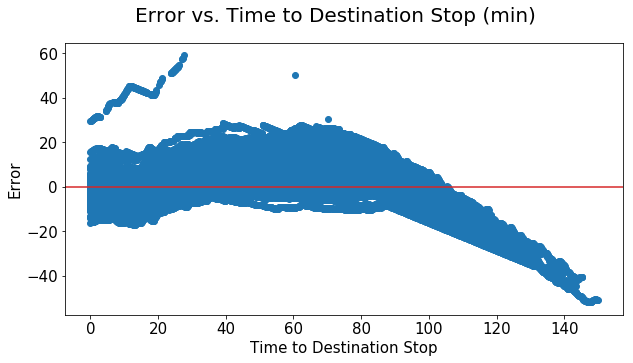

In [343]:
fig, ax = plt.subplots()
plt.scatter(test["delta_t_end"]/60,(predictions-test["delta_t_end"])/60)
ax.axhline(y=0,color="tab:red")
fig.suptitle('Error vs. Time to Destination Stop (min)', fontsize=20)
ax.set_xlabel('Time to Destination Stop')
ax.set_ylabel('Error')
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
plt.tick_params(axis='both', which='major', labelsize=15)

In [300]:
trip_duration = (complete_df.set_index("shift_num")["destination_time"]-complete_df.set_index("shift_num")["starting_time"]).apply(lambda x: x)

In [302]:
trip_duration = trip_duration.groupby("shift_num").first()

In [314]:
trip_duration_seconds = trip_duration.astype('timedelta64[s]')
trip_duration_minutes = trip_duration.astype('timedelta64[m]')

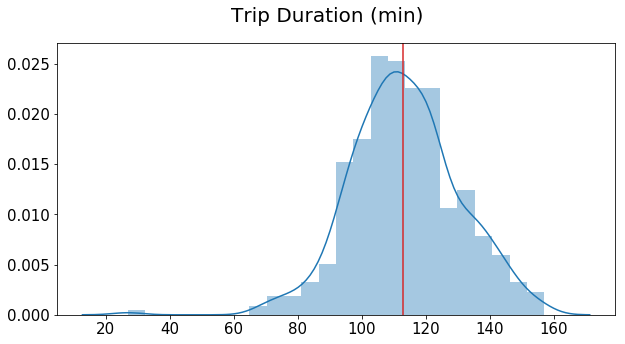

In [344]:
import seaborn as sns

fig, ax = plt.subplots()
sns.distplot(trip_duration_minutes, ax=ax, norm_hist=True)
ax.axvline(x=np.median(trip_duration_minutes),color="tab:red")
fig.suptitle('Trip Duration (min)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)

In [321]:
hours = trip_duration_seconds // 3600
minutes = (trip_duration_seconds - hours * 3600) // 60
seconds = trip_duration_seconds - hours * 3600 - minutes * 60

In [327]:
trip_duration[0]

numpy.timedelta64(5977000000000,'ns')

In [322]:
pd.concat([hours, minutes, seconds],axis=1)

,0,1,2
shift_num,,,
0.0,1.0,39.0,37.0
1.0,1.0,9.0,29.0
2.0,1.0,39.0,46.0
3.0,1.0,34.0,30.0
4.0,1.0,36.0,11.0
5.0,1.0,22.0,14.0
6.0,1.0,26.0,7.0
7.0,1.0,24.0,17.0
8.0,2.0,16.0,24.0
